# Collecting Data

In [2]:
import pandas as pd
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType

In [3]:
START_YEAR, END_YEAR = 2010, 2020

for year in range(START_YEAR, END_YEAR):
    client.season_schedule(
        season_end_year=year, 
        output_type=OutputType.CSV, 
        output_file_path = "./games/allgames%s.csv" % str(year)
    )

In [4]:
shortened_years = {
    2012: 990, 
    2013: 1229 
}

allgames = [pd.read_csv("./games/allgames%s.csv" % (year)).iloc[range(0, 1230), :] if year not in shortened_years 
            else pd.read_csv("./games/allgames%s.csv" % (year)).iloc[range(0, shortened_years[year]), :]  
            for year in range(START_YEAR, END_YEAR)]

In [5]:
# add column for home win
for game in allgames: 
    game["home_team_win?"] = game["home_team_score"] > game["away_team_score"]

    
# what is the home team win % over these 3 regular seasons? 
num_home_wins = sum([game["home_team_win?"].sum() for game in allgames]) 
num_games = sum([game.shape[0] for game in allgames])

home_win_percentage = num_home_wins / num_games 
print(home_win_percentage)

0.5896011277883738


# Finding Travel Distance Between Each Road Game

# Some Definitions: 
###### road trip: Any continuous stretch of away games directly following a home game (the length is the # of games played)
###### cumulative distance: Refers to the total distance traveled from game to game during a road trip 
###### n game road trip: A road trip of length n


#### Some Notes: 
###### An n game road trip may be a fraction of a larger road trip. For example, a 5 game road trip consists of a 4 game road trip, a 3 game road trip, etc...
###### Therefore, when I refer to a n game road trip, it does not imply that the n + 1 game is a home game. 
###### However, all road trips start from the first away game following a home game. For example, the last 3 games of a 5 game road trip is not a 3 game road trip. However, the first 3 games of a 5 game road trip is a 3 game road trip. 
###### All travel distances are approximated as the distance between the home cities of each team. For example, If the 76ers played an away  game against the Celtics, the distance traveled would be estimated as the distance between Philadelphia and Boston, according to this API: https://www.distance24.org/api.xhtml
###### I did not consider games played between the Clippers and Lakers in my calculations, as they share a stadium, which pretty much defeats the purpose of home v. away. 


In [7]:
# Map each team to its home city 

team_cities = {
    "PHILADELPHIA 76ERS": "Philadelphia" , 
    "LOS ANGELES LAKERS": "Los Angeles" , 
    "NEW ORLEANS PELICANS": "New Orleans" , 
    "PORTLAND TRAIL BLAZERS": "Portland" , 
    "PHOENIX SUNS": "Phoenix" , 
    "MEMPHIS GRIZZLIES": "Memphis",
    "SAN ANTONIO SPURS" : "San Antonio", 
    "WASHINGTON WIZARDS" : "Washington DC", 
    "CHARLOTTE HORNETS" : "Charlotte", 
    "ORLANDO MAGIC" : "Orlando", 
    "BOSTON CELTICS" : "Boston", 
    "INDIANA PACERS" : "Indiana", 
    "UTAH JAZZ" : "Salt Lake City", 
    "LOS ANGELES CLIPPERS": "Los Angeles", 
    "CHICAGO BULLS" : "Chicago", 
    "NEW YORK KNICKS": "New York City", 
    "BROOKLYN NETS": "Brooklyn", 
    "HOUSTON ROCKETS": "Houston", 
    "DALLAS MAVERICKS" : "Dallas", 
    "GOLDEN STATE WARRIORS": "San Francisco", 
    "MINNESOTA TIMBERWOLVES" : "Minneapolis", 
    "ATLANTA HAWKS" : "Atlanta", 
    "OKLAHOMA CITY THUNDER" : "Oklahoma City", 
    "MIAMI HEAT" : "Miami", 
    "DENVER NUGGETS" : "Denver", 
    "DETROIT PISTONS" : "Detroit", 
    "SACRAMENTO KINGS" : "Sacramento",  
    "TORONTO RAPTORS" : "Toronto", 
    "CLEVELAND CAVALIERS" : "Cleveland", 
    "MILWAUKEE BUCKS" : "Milwaukee",
    "NEW JERSEY NETS" : "East Rutherford", 
    "CHARLOTTE BOBCATS" : "Charlotte", 
    "NEW ORLEANS HORNETS" : "New Orleans" 
}

In [9]:
# Lets find out if winning an away game is correlated with distance traveled 
import json
import requests

class TeamTravelingVsWinning: 
    def __init__(self, team, year):
        # each object of this class will be associated with a unique NBA team and year 
        self.year = year 
        self.team = team  
        
        self.home_city = team_cities[team]  # city of the team 
        self.curr_city = team_cities[team]  # current location of the team (initialized to the home city)
        self.games_played = 0  # keeps track of the current game # 
        
        num_games = 82 if year != 2012 else 66 # only 66 games were played in the 2011-12 season
        
        if self.year == 2013:
            if self.team == "BOSTON CELTICS" or self.team == "INDIANA PACERS": # 1 game cancelled bc of boston marathon bombing  
                num_games = 81 
        
        #  As we iterate through the season's games, we will maintain this table for each team 
        self.table = {
            "cumulative_distance" : [0 for i in range(num_games)], 
            "n_game_road_trip" : [0 for i in range(num_games)], 
            "win?" : [None for i in range(num_games)]
        }
        
        # The teams dictionary will store a team for every (year, team) combination
        # Some combinations will be invalid, for instance the Charlotte Bobcats were not a team after 2013-14
        self.valid = False 
    
    def add_game(self, home_team, h_pnts, v_pnts):
        if  self.home_city != team_cities[home_team]: 
            cities = "stops=%s|%s" % (self.curr_city, team_cities[home_team])
            ep = "https://www.distance24.org/route.json?%s" % cities
            dist = requests.get(ep).json()["distance"]
            prev_road_count = self.table["n_game_road_trip"][self.games_played - 1]
            prev_cumulative_dist = self.table["cumulative_distance"][self.games_played - 1]
            self.table["n_game_road_trip"][self.games_played] = prev_road_count + 1 
            self.table["cumulative_distance"][self.games_played] = prev_cumulative_dist + dist 
        else: 
            self.table["n_game_road_trip"][self.games_played] = 0 
            self.table["cumulative_distance"][self.games_played] = 0 
        if self.team == home_team: 
            self.table["win?"][self.games_played] = 1 if h_pnts > v_pnts else 0 
        else: 
            self.table["win?"][self.games_played] = 0 if h_pnts > v_pnts else 1 
        self.valid = True # if this method is accessed, it means that this team is "valid" 
        self.games_played += 1  
        self.curr_city = team_cities[home_team] 

teams = {} 
for year in range(START_YEAR, END_YEAR): 
    for team in team_cities: 
        teams[(team, year)] = TeamTravelingVsWinning(team, year)

for year in range(START_YEAR, END_YEAR): 
    print(str((year - START_YEAR) / (END_YEAR - START_YEAR) * 100) + '% done')
    for row in allgames[year - START_YEAR].iterrows():
        visitor = row[1].loc["away_team"]
        home_team = row[1].loc["home_team"] 
        h_pnts = row[1].loc["home_team_score"] 
        v_pnts = row[1].loc["away_team_score"]
        teams[(visitor, year)].add_game(home_team, h_pnts, v_pnts) 
        teams[(home_team, year)].add_game(home_team, h_pnts, v_pnts) 

print("100% done")
        
        

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100% done


In [10]:
# Lets save each team's table as a csv, because that took a while to calculate 
dfs = {(team, year):pd.DataFrame.from_dict(data.table) for (team, year), data in teams.items() 
       if data.valid}
for (team, year), df in dfs.items(): 
    name = "%s%s.csv" % (team, year)
    path = 'TeamTravelDistVsWinning/%s' % name
    df.to_csv(path, index = False)


In [14]:
# Now, let's compile each teams data into one big DataFrame

team_travel_data = []
for year in range(START_YEAR, END_YEAR):
    for team, city in team_cities.items(): 
        file = "%s%s.csv" % (team, year) 
        try:
            team_travel_data.append(pd.read_csv('TeamTravelDistVsWinning/%s' % file))
        except FileNotFoundError: # not every team, city combination is a valid team 
            continue 

complete_data = pd.concat(team_travel_data)

# delete home games 
complete_data = complete_data[complete_data['n_game_road_trip'] > 0]

# get table sorted by distance
complete_data.sort_values(by = ['cumulative_distance', 'n_game_road_trip'], inplace = True)

# reset indices 
complete_data.reset_index(drop=True, inplace=True)

# there are only 1226 games shown because of the 4 Lakers Clippers matchups 
display(complete_data)

complete_data['cumulative_distance'].describe()
# complete_data['n_game_road_trip'].describe()




,cumulative_distance,n_game_road_trip,win?
0,8,1,0
1,8,1,1
2,8,1,0
3,8,1,1
4,8,1,1
...,...,...,...
12015,11169,6,0
12016,11282,8,1
12017,11427,9,0
12018,12482,9,0


count    12020.000000
mean      2548.822463
std       1885.250738
min          8.000000
25%       1067.000000
50%       2051.000000
75%       3628.000000
max      13039.000000
Name: cumulative_distance, dtype: float64

In [18]:
# Explore sample size for each road trip length for different values of n 

for i in range(1, 11):
    print("n = %s:" % str(i), complete_data[complete_data['n_game_road_trip'] == i].shape[0])

n = 1: 5965
n = 2: 3039
n = 3: 1581
n = 4: 814
n = 5: 372
n = 6: 157
n = 7: 58
n = 8: 25
n = 9: 8
n = 10: 1


In [19]:
# We have to figure out a way to bin this data 
# It makes the most sense to do bins of 1, 2, 3, 4, 5, 6 and > 6 so each bin is sufficiently large

AWAY_WIN_PERCENTAGE = 1 - home_win_percentage 

data_dict = {
    "sample size": [],
    "nth game of road trip": [],
    "mean travel distance" : [],
    "games won" : [], 
    "expected games won" : [], # if winning is independent of the length of road trip, how many games should be won? 
    "win %" : []
}
for i in range(1, 7): # first we will calculate the data for the bins 1 - 6
    i_data = complete_data[complete_data['n_game_road_trip'] == i]
    i_games_won = int(i_data['win?'].sum()) 
    i_size = i_data.shape[0] 
    i_winpercentage = i_games_won / i_size
    i_mean_traveldist = i_data["cumulative_distance"].mean()
    data_dict["sample size"].append(i_size)
    data_dict["win %"].append(i_winpercentage)
    data_dict["nth game of road trip"].append(str(i)) 
    data_dict["mean travel distance"].append(i_mean_traveldist)
    data_dict["games won"].append(i_games_won) 
    data_dict["expected games won"].append(int(i_size * AWAY_WIN_PERCENTAGE))

# for road trips of size > 6
greater_than_6 = complete_data[complete_data['n_game_road_trip'] > 6] 
data_dict["sample size"].append(greater_than_6.shape[0]) 
data_dict["win %"].append(greater_than_6["win?"].sum() / greater_than_6.shape[0])
data_dict["nth game of road trip"].append(">6") 
data_dict["mean travel distance"].append(greater_than_6["cumulative_distance"].mean())
data_dict["games won"].append(int(greater_than_6["win?"].sum())) 
data_dict["expected games won"].append(int(greater_than_6.shape[0] * AWAY_WIN_PERCENTAGE))

wins_vs_roadtrip = pd.DataFrame.from_dict(data_dict) 
    
display(wins_vs_roadtrip) 

,sample size,nth game of road trip,mean travel distance,games won,expected games won,win %
0,5965,1,1298.250293,2461,2448,0.412573
1,3039,2,2666.405067,1231,1247,0.405067
2,1581,3,3947.884250,637,648,0.402910
3,814,4,5218.847666,327,334,0.401720
4,372,5,6243.266129,166,152,0.446237
5,157,6,7337.318471,70,64,0.445860
6,92,>6,8971.489130,40,37,0.434783


In [20]:
# is this data significant?

from scipy.stats import chisquare

results = chisquare(data_dict["games won"], data_dict["expected games won"])

print(results) 

# There is about an 85% chance that these results are strongly


Power_divergenceResult(statistic=2.70298055954023, pvalue=0.845095121042608)


# Visualizations

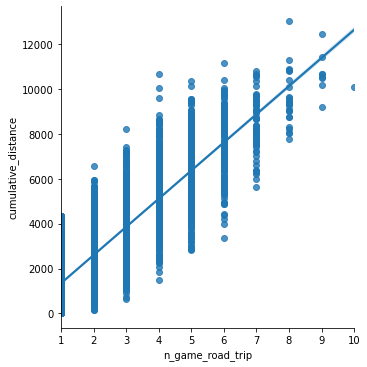

In [21]:
# Visualization of distance traveled vs length of trip 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x = "n_game_road_trip", y = "cumulative_distance", data = complete_data)
